In [1]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt
import seaborn as sns

dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

In [2]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [3]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [4]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [5]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [6]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [7]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [8]:
train=X_train
test=X_test
valid=X_valid

<Axes: >

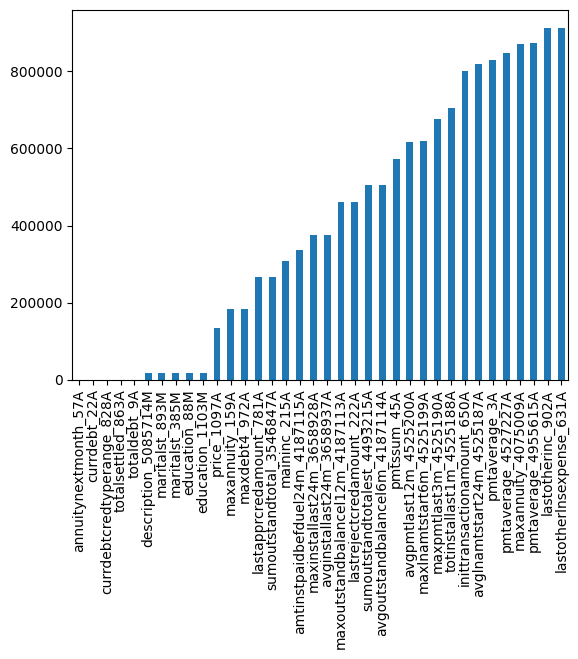

In [9]:
#查看缺失值
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [10]:
#删除缺失值最多的两个特征
missing_counts = df.isnull().sum()
# 排序并找出缺失值最多的四列
columns_to_drop = missing_counts.nlargest(4).index

train.drop(columns=columns_to_drop)
test.drop(columns=columns_to_drop)

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,totalsettled_863A,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtssum_45A
0,NaN,3390.2000,0.0,NaN,NaN,NaN,NaN,44000.0,0.000,0.000,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,9568.6010,0.0,NaN,NaN,NaN,NaN,100000.0,0.000,0.000,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,5109.6000,0.0,NaN,NaN,NaN,NaN,80000.0,0.000,0.000,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2581.0000,0.0,NaN,NaN,NaN,NaN,28000.0,0.000,0.000,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2400.0000,0.0,NaN,NaN,NaN,NaN,40000.0,0.000,0.000,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305327,119089.99,4138.4000,0.0,5671.000,NaN,20909.320,6878.8003,40000.0,0.000,0.000,...,364041.40,12445.385,2fc785b2,717ddd49,a55475b1,3439d993,a55475b1,NaN,NaN,NaN
305328,0.00,4747.2000,0.0,NaN,NaN,NaN,NaN,60000.0,0.000,0.000,...,5000.00,NaN,2fc785b2,6b2ae0fa,6b2ae0fa,3439d993,46b968c3,NaN,NaN,NaN
305329,335469.25,7088.6000,7216.0,13376.601,NaN,109874.586,14549.0000,100000.0,87968.875,87968.875,...,818424.20,7216.000,2fc785b2,717ddd49,a55475b1,3439d993,a55475b1,NaN,NaN,NaN
305330,169487.72,4960.8003,2717.2,7369.000,NaN,12492.798,10033.2000,60000.0,7647.200,0.000,...,378544.75,2717.200,2fc785b2,717ddd49,a55475b1,3439d993,a55475b1,NaN,NaN,NaN


In [11]:
numerical_fea = list(train.select_dtypes(exclude=['category']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(train.columns)))

In [12]:
cate_features = train[category_fea]
for f in cate_features:
    print(f, '类型数：', train[f].nunique())

lastapprcommoditycat_1041M 类型数： 44
lastapprcommoditytypec_5251766M 类型数： 188
lastcancelreason_561M 类型数： 73
lastrejectcommoditycat_161M 类型数： 42
lastrejectcommodtypec_5251769M 类型数： 160
lastrejectreason_759M 类型数： 18
lastrejectreasonclient_4145040M 类型数： 14
previouscontdistrict_112M 类型数： 223
description_5085714M 类型数： 2
education_1103M 类型数： 5
education_88M 类型数： 5
maritalst_385M 类型数： 6
maritalst_893M 类型数： 6


In [13]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# 假设 category_fea 是一个包含所有分类特征列名的列表

for col in tqdm(category_fea):
    le = LabelEncoder()
    # 拟合 LabelEncoder
    le.fit(list(train[col].astype(str)) + list(test[col].astype(str)) + list(valid[col].astype(str)))
    # 转换每个 DataFrame 的列
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
    valid[col] = le.transform(valid[col].astype(str))

print('Label Encoding 完成')

import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer


# 计算相关系数矩阵
corr_matrix = train.corr()
# 保证所有数据都是数值型
for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].astype('category').cat.codes

# 确定使用均值填补还是KNN填补的列
mean_fill_cols = [col for col in corr_matrix.columns]

mean_imputer = SimpleImputer(strategy='mean')
train[mean_fill_cols] = mean_imputer.fit_transform(train[mean_fill_cols])

import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer


# 计算相关系数矩阵
corr_matrix = test.corr()
# 保证所有数据都是数值型
for col in test.columns:
    if test[col].dtype == 'object':
        test[col] = test[col].astype('category').cat.codes

# 确定使用均值填补还是KNN填补的列
mean_fill_cols = [col for col in corr_matrix.columns]

mean_imputer = SimpleImputer(strategy='mean')
test[mean_fill_cols] = mean_imputer.fit_transform(test[mean_fill_cols])


# 计算相关系数矩阵
corr_matrix = valid.corr()
# 保证所有数据都是数值型
for col in valid.columns:
    if valid[col].dtype == 'object':
        valid[col] = valid[col].astype('category').cat.codes

# 确定使用均值填补还是KNN填补的列
mean_fill_cols = [col for col in corr_matrix.columns]

mean_imputer = SimpleImputer(strategy='mean')
valid[mean_fill_cols] = mean_imputer.fit_transform(valid[mean_fill_cols])

100%|██████████| 13/13 [00:34<00:00,  2.68s/it]


Label Encoding 完成


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915995 entries, 0 to 915994
Data columns (total 49 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       915995 non-null  int64  
 1   amtinstpaidbefduel24m_4187115A   915995 non-null  float64
 2   annuity_780A                     915995 non-null  float64
 3   annuitynextmonth_57A             915995 non-null  float64
 4   avginstallast24m_3658937A        915995 non-null  float64
 5   avglnamtstart24m_4525187A        915995 non-null  float64
 6   avgoutstandbalancel6m_4187114A   915995 non-null  float64
 7   avgpmtlast12m_4525200A           915995 non-null  float64
 8   credamount_770A                  915995 non-null  float64
 9   currdebt_22A                     915995 non-null  float64
 10  currdebtcredtyperange_828A       915995 non-null  float64
 11  disbursedcredamount_1113A        915995 non-null  float64
 12  do

In [17]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915995 entries, 0 to 915994
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Unnamed: 0  915995 non-null  int64
 1   target      915995 non-null  int64
dtypes: int64(2)
memory usage: 14.0 MB


In [18]:
y_train.head()

,Unnamed: 0,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [19]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305332 entries, 0 to 305331
Data columns (total 49 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       305332 non-null  int64  
 1   amtinstpaidbefduel24m_4187115A   305332 non-null  float64
 2   annuity_780A                     305332 non-null  float64
 3   annuitynextmonth_57A             305332 non-null  float64
 4   avginstallast24m_3658937A        305332 non-null  float64
 5   avglnamtstart24m_4525187A        305332 non-null  float64
 6   avgoutstandbalancel6m_4187114A   305332 non-null  float64
 7   avgpmtlast12m_4525200A           305332 non-null  float64
 8   credamount_770A                  305332 non-null  float64
 9   currdebt_22A                     305332 non-null  float64
 10  currdebtcredtyperange_828A       305332 non-null  float64
 11  disbursedcredamount_1113A        305332 non-null  float64
 12  do

In [20]:
y_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305332 entries, 0 to 305331
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Unnamed: 0  305332 non-null  int64
 1   target      305332 non-null  int64
dtypes: int64(2)
memory usage: 4.7 MB


In [21]:
train.head()

,Unnamed: 0,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,0,56051.029646,1917.6,0.0,5399.340343,44660.797975,45983.769643,6398.226506,30000.0,0.0,...,10417.497928,2.0,5.0,5.0,6.0,6.0,9314.901329,10052.182398,17616.446469,13232.382356
1,1,56051.029646,4937.0,0.0,5399.340343,44660.797975,45983.769643,6398.226506,78000.0,0.0,...,10417.497928,2.0,5.0,5.0,6.0,6.0,9314.901329,10052.182398,17616.446469,13232.382356
2,2,56051.029646,3600.0,0.0,5399.340343,44660.797975,45983.769643,6398.226506,60000.0,0.0,...,10417.497928,2.0,5.0,5.0,6.0,6.0,9314.901329,10052.182398,17616.446469,13232.382356
3,3,56051.029646,3110.8,0.0,5399.340343,44660.797975,45983.769643,6398.226506,20000.0,0.0,...,10417.497928,2.0,5.0,5.0,6.0,6.0,9314.901329,10052.182398,17616.446469,13232.382356
4,4,56051.029646,1218.0,0.0,5399.340343,44660.797975,45983.769643,6398.226506,20300.0,0.0,...,10417.497928,2.0,5.0,5.0,6.0,6.0,9314.901329,10052.182398,17616.446469,13232.382356


In [22]:
test.head()

,Unnamed: 0,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,0,55969.827331,3390.200,0.0,5423.366237,45341.343885,46153.819084,6458.24748,44000.0,0.0,...,10420.04392,2.0,5.0,5.0,6.0,6.0,9304.646423,10000.914138,17784.814373,13171.107301
1,1,55969.827331,9568.601,0.0,5423.366237,45341.343885,46153.819084,6458.24748,100000.0,0.0,...,10420.04392,2.0,5.0,5.0,6.0,6.0,9304.646423,10000.914138,17784.814373,13171.107301
2,2,55969.827331,5109.600,0.0,5423.366237,45341.343885,46153.819084,6458.24748,80000.0,0.0,...,10420.04392,2.0,5.0,5.0,6.0,6.0,9304.646423,10000.914138,17784.814373,13171.107301
3,3,55969.827331,2581.000,0.0,5423.366237,45341.343885,46153.819084,6458.24748,28000.0,0.0,...,10420.04392,2.0,5.0,5.0,6.0,6.0,9304.646423,10000.914138,17784.814373,13171.107301
4,4,55969.827331,2400.000,0.0,5423.366237,45341.343885,46153.819084,6458.24748,40000.0,0.0,...,10420.04392,2.0,5.0,5.0,6.0,6.0,9304.646423,10000.914138,17784.814373,13171.107301


In [23]:
valid.head()

,Unnamed: 0,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,0,55668.79703,3134.0,0.0,5386.565339,44259.932884,45818.417936,6364.762599,19999.8,0.0,...,10384.274382,2.0,5.0,5.0,6.0,6.0,9266.439843,10010.635772,17625.351023,13131.160426
1,1,55668.79703,4643.6,0.0,5386.565339,44259.932884,45818.417936,6364.762599,40000.0,0.0,...,10384.274382,2.0,5.0,5.0,6.0,6.0,9266.439843,10010.635772,17625.351023,13131.160426
2,2,55668.79703,4929.4,0.0,5386.565339,44259.932884,45818.417936,6364.762599,64000.0,0.0,...,10384.274382,2.0,5.0,5.0,6.0,6.0,9266.439843,10010.635772,17625.351023,13131.160426
3,3,55668.79703,4471.0,0.0,5386.565339,44259.932884,45818.417936,6364.762599,70000.0,0.0,...,10384.274382,2.0,5.0,5.0,6.0,6.0,9266.439843,10010.635772,17625.351023,13131.160426
4,4,55668.79703,3794.2,0.0,5386.565339,44259.932884,45818.417936,6364.762599,44000.0,0.0,...,10384.274382,2.0,5.0,5.0,6.0,6.0,9266.439843,10010.635772,17625.351023,13131.160426


In [24]:
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)
valid.drop('Unnamed: 0', axis=1, inplace=True)


In [25]:
train.head()

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,56051.029646,1917.6,0.0,5399.340343,44660.797975,45983.769643,6398.226506,30000.0,0.0,0.0,...,10417.497928,2.0,5.0,5.0,6.0,6.0,9314.901329,10052.182398,17616.446469,13232.382356
1,56051.029646,4937.0,0.0,5399.340343,44660.797975,45983.769643,6398.226506,78000.0,0.0,0.0,...,10417.497928,2.0,5.0,5.0,6.0,6.0,9314.901329,10052.182398,17616.446469,13232.382356
2,56051.029646,3600.0,0.0,5399.340343,44660.797975,45983.769643,6398.226506,60000.0,0.0,0.0,...,10417.497928,2.0,5.0,5.0,6.0,6.0,9314.901329,10052.182398,17616.446469,13232.382356
3,56051.029646,3110.8,0.0,5399.340343,44660.797975,45983.769643,6398.226506,20000.0,0.0,0.0,...,10417.497928,2.0,5.0,5.0,6.0,6.0,9314.901329,10052.182398,17616.446469,13232.382356
4,56051.029646,1218.0,0.0,5399.340343,44660.797975,45983.769643,6398.226506,20300.0,0.0,0.0,...,10417.497928,2.0,5.0,5.0,6.0,6.0,9314.901329,10052.182398,17616.446469,13232.382356


In [26]:
numerical_fea = list(train.select_dtypes(exclude=['category']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(train.columns)))

In [27]:
train['label']=y_train['target']
valid['label']=y_valid['target']

In [28]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

for fea in numerical_fea:
    train = find_outliers_by_3segama(train,fea)
    print(train[fea+'_outliers'].value_counts())
    print('*'*10)

for fea in numerical_fea:
    valid = find_outliers_by_3segama(valid,fea)
    print(valid[fea+'_outliers'].value_counts())
    print('*'*10)

amtinstpaidbefduel24m_4187115A_outliers
正常值    893497
异常值     22498
Name: count, dtype: int64
**********
annuity_780A_outliers
正常值    902440
异常值     13555
Name: count, dtype: int64
**********
annuitynextmonth_57A_outliers
正常值    896489
异常值     19506
Name: count, dtype: int64
**********
avginstallast24m_3658937A_outliers
正常值    908461
异常值      7534
Name: count, dtype: int64
**********
avglnamtstart24m_4525187A_outliers
正常值    902850
异常值     13145
Name: count, dtype: int64
**********
avgoutstandbalancel6m_4187114A_outliers
正常值    895148
异常值     20847
Name: count, dtype: int64
**********
avgpmtlast12m_4525200A_outliers
正常值    908740
异常值      7255
Name: count, dtype: int64
**********
credamount_770A_outliers
正常值    898700
异常值     17295
Name: count, dtype: int64
**********
currdebt_22A_outliers
正常值    892239
异常值     23756
Name: count, dtype: int64
**********
currdebtcredtyperange_828A_outliers
正常值    893319
异常值     22676
Name: count, dtype: int64
**********
disbursedcredamount_1113A_outlier

In [29]:
#删除异常值
for fea in numerical_fea:
    train = train[train[fea+'_outliers']=='正常值']
    train = train.reset_index(drop=True) 

for fea in numerical_fea:
    valid = valid[valid[fea+'_outliers']=='正常值']
    valid = valid.reset_index(drop=True)

In [30]:
#删除异常值后的数据
train.drop([fea+'_outliers' for fea in numerical_fea], axis=1, inplace=True)
valid.drop([fea+'_outliers' for fea in numerical_fea], axis=1, inplace=True)

In [31]:
#查看特征的缺失情况
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

missing_values_table(train)

Your selected dataframe has 49 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [32]:
#过滤数值型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []#连续型特征
    numerical_noserial_fea = []#非连续数值型类别特征
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(train,numerical_fea)

In [33]:
#检验存在偏态
def skew(data):
    skew_value = data.skew()
    skew_fea = skew_value[abs(skew_value) > 0.6].index
    return skew_fea,skew_value
skew_fea,skew_value = skew(train[numerical_serial_fea])

#对数变换
train[skew_fea] = np.log1p(train[skew_fea])
valid[skew_fea] = np.log1p(valid[skew_fea])
test[skew_fea] = np.log1p(test[skew_fea])


/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [34]:
#标准化
scaler = StandardScaler()
#fit_transform()的作用就是先拟合数据，然后转化它将其转化为标准形式
#fit_transform和transform的功能是一样的，都是将数据转换为标准形式
train[numerical_fea] = scaler.fit_transform(train[numerical_fea])
valid[numerical_fea] = scaler.transform(valid[numerical_fea])
test[numerical_fea] = scaler.transform(test[numerical_fea])

In [35]:
train.head()

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,label
0,0.457158,1.539194,-0.562637,0.498979,0.210275,0.408273,0.34345,1.507410,-0.599166,-0.442653,...,0.315473,0.726298,0.001389,0.411338,0.003743,0.150020,0.142158,0.097955,0.065539,0
1,0.457158,-0.160136,-0.562637,0.498979,0.210275,0.408273,0.34345,0.362316,-0.599166,-0.442653,...,0.315473,0.726298,0.001389,0.411338,0.003743,0.150020,0.142158,0.097955,-0.107627,0
2,0.457158,-0.983304,-0.562637,0.498979,0.210275,0.408273,0.34345,-1.300128,-0.599166,-0.442653,...,0.315473,-0.317082,0.001389,1.268307,0.003743,0.150020,0.142158,0.097955,0.068188,0
3,0.457158,1.193479,-0.562637,0.498979,0.210275,0.408273,0.34345,1.591807,-0.599166,-0.442653,...,0.315473,-1.360462,0.001389,-1.302600,0.003743,0.150020,0.142158,0.097955,0.116888,0
4,0.457158,1.193479,-0.562637,0.498979,0.210275,0.408273,0.34345,1.591807,-0.599166,-0.442653,...,0.315473,0.726298,0.001389,0.411338,0.003743,-5.999115,0.142158,0.097955,0.351316,0


In [36]:
test.head()

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,0.456734,0.272276,-0.562637,0.507382,0.263196,0.417063,0.377898,0.472009,-0.599166,-0.442653,...,0.260403,3.800789,2.813057,411.433433,3.839214,175.061511,0.13754,0.071523,0.488413,0.349528
1,0.456734,1.946698,-0.562637,0.507382,0.263196,0.417063,0.377898,1.591807,-0.599166,-0.442653,...,0.260403,3.800789,2.813057,411.433433,3.839214,175.061511,0.13754,0.071523,0.488413,0.349528
2,0.456734,0.934249,-0.562637,0.507382,0.263196,0.417063,0.377898,1.287443,-0.599166,-0.442653,...,0.260403,3.800789,2.813057,411.433433,3.839214,175.061511,0.13754,0.071523,0.488413,0.349528
3,0.456734,-0.167744,-0.562637,0.507382,0.263196,0.417063,0.377898,-0.144480,-0.599166,-0.442653,...,0.260403,3.800789,2.813057,411.433433,3.839214,175.061511,0.13754,0.071523,0.488413,0.349528
4,0.456734,-0.285051,-0.562637,0.507382,0.263196,0.417063,0.377898,0.342009,-0.599166,-0.442653,...,0.260403,3.800789,2.813057,411.433433,3.839214,175.061511,0.13754,0.071523,0.488413,0.349528


# 模型

xgboost

In [37]:
#使用xgboost进行训练
import xgboost as xgb
from sklearn.metrics import accuracy_score

x_train = train.drop(columns=['label'])
y_train = train['label']

x_train.shape

(592466, 48)

In [38]:
#训练模型
model = xgb.XGBClassifier(max_depth=7,learning_rate=0.1,n_estimators=100)
model.fit(x_train,y_train)

#在验证集上进行预测
x_valid = valid.drop(columns=['label'])
y_valid = valid['label']
y_pred = model.predict(x_valid)
accuracy = accuracy_score(y_valid,y_pred)
print('accuracy:',accuracy)

accuracy: 0.9695536566058416


In [39]:
#在测试集上进行预测
x_test = test
y_pred = model.predict(x_test)

In [43]:
df_subm = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")

In [44]:
df_subm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   case_id  10 non-null     int64  
 1   score    10 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 288.0 bytes


In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305332 entries, 0 to 305331
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   amtinstpaidbefduel24m_4187115A   305332 non-null  float64
 1   annuity_780A                     305332 non-null  float64
 2   annuitynextmonth_57A             305332 non-null  float64
 3   avginstallast24m_3658937A        305332 non-null  float64
 4   avglnamtstart24m_4525187A        305332 non-null  float64
 5   avgoutstandbalancel6m_4187114A   305332 non-null  float64
 6   avgpmtlast12m_4525200A           305332 non-null  float64
 7   credamount_770A                  305332 non-null  float64
 8   currdebt_22A                     305332 non-null  float64
 9   currdebtcredtyperange_828A       305332 non-null  float64
 10  disbursedcredamount_1113A        305332 non-null  float64
 11  downpmt_116A                     305332 non-null  float64
 12  in

In [58]:
data_submission

case_id,date_decision,MONTH,WEEK_NUM,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,disbursedcredamount_1113A,downpmt_116A,inittransactionamount_650A,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastcancelreason_561M,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectreason_759M,lastrejectreasonclient_4145040M,maininc_215A,maxannuity_159A,maxannuity_4075009A,maxdebt4_972A,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,previouscontdistrict_112M,price_1097A,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,mainoccupationinc_384A_max,mainoccupationinc_384A_any_selfemployed,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
i64,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,str,f64,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,bool,str,f64,bool
57543,"""2021-05-14""",202201,100,191767.36,3674.6,1218.2001,16049.4,17054.4,14554.4,24482.0,20000.0,12154.4,0.0,20000.0,0.0,null,"""a55475b1""","""a55475b1""",14000.0,"""a55475b1""",null,null,"""P109_133_183""","""P49_111_165""",24000.0,"""a55475b1""","""a55475b1""",34000.0,280983.56,null,231440.03,131700.8,16672.6,157731.78,16641.4,"""a55475b1""",0.0,12154.4,12154.4,12154.4,456031.1,17859.6,"""2fc785b2""","""6b2ae0fa""","""a55475b1""","""38c061ee""","""a55475b1""",null,null,null,null,34000.0,false,null,null,null
57549,"""2022-01-17""",202201,100,129704.4,5742.6,3546.6,32426.201,118964.805,13681.714,32426.201,75000.0,10638.2,10638.2,75000.0,0.0,null,"""a55475b1""","""a55475b1""",94000.0,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",160000.0,"""a55475b1""","""P30_86_84""",44000.0,337659.8,null,34066.0,122511.4,31820.6,21278.0,122511.4,"""a55475b1""",null,10638.2,10638.2,10638.2,373720.84,126058.0,"""2fc785b2""","""39a0853f""","""a55475b1""","""a7fcb6e5""","""a55475b1""",null,null,26815.6,null,49800.0,false,null,null,null
57551,"""2020-11-27""",202201,100,71036.4,2844.6,0.0,8357.2,null,0.0,9551.0,27095.201,0.0,0.0,27095.201,0.0,null,"""a55475b1""","""a55475b1""",200000.0,"""P85_114_140""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",70000.0,83400.0,null,54000.0,41783.402,54000.0,62619.0,null,"""P11_36_178""",27095.201,0.0,0.0,0.0,75219.0,null,"""2fc785b2""","""6b2ae0fa""","""a55475b1""","""3439d993""","""a55475b1""",null,null,null,null,59600.0,false,null,null,null
57552,"""2020-11-27""",202201,100,183992.0,6298.8003,12155.4,7440.4,null,199322.4,9148.4,100000.0,191269.61,191269.61,100000.0,0.0,null,"""a55475b1""","""a55475b1""",0.0,"""P94_109_143""",null,null,"""a55475b1""","""a55475b1""",150000.0,"""a55475b1""","""P94_109_143""",null,110500.0,null,188126.14,12155.4,104473.6,288642.6,12155.4,"""P21_87_50""",null,191269.61,191269.61,191269.61,284213.0,18889.0,"""2fc785b2""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,23402.8,null,112000.0,false,"""OWNED""",null,null
57569,"""2021-12-20""",202201,100,0.0,4682.6,0.0,null,null,null,10796.4,60000.0,0.0,0.0,60000.0,0.0,null,"""a55475b1""","""a55475b1""",20000.0,"""P94_109_143""",null,null,"""a55475b1""","""a55475b1""",40000.0,"""a55475b1""","""P94_109_143""",6000.0,37704.0,null,64555.668,null,null,0.0,null,"""a55475b1""",null,0.0,0.0,0.0,95348.42,null,"""2fc785b2""","""717ddd49""","""a55475b1""","""3439d993""","""a55475b1""",null,null,17333.6,null,58000.0,false,"""OWNED""",null,null
57630,"""2021-03-16

In [64]:
submission = pd.DataFrame(y_pred,columns=['score'])
#设置索引match_id从57543开始
submission['match_id']=range(57543,57543+len(submission))
submission = submission[['match_id','score']]
submission.to_csv('./submission.csv',index=True)